## Setup

In [1]:
import xarray as xr
import numpy as np
import pandas as pd

In [288]:
SILO_path = "/Users/phelps/PhD/DATA/climate/SILO/processed/flux_sites"
fluxdata_path ="/Users/phelps/PhD/DATA/ozflux/L6"

## Functions

In [420]:
def load_silo_site(ncfile):
    ds = xr.open_dataset(ncfile)

    # Drop lat/lon dimensions (they are length 1)
    ds = ds.squeeze(drop=True)

    # Convert time to datetime
    ds['time'] = pd.to_datetime(ds['time'].values)

    # Mask fill values
    for v in ds.data_vars:
        if '_FillValue' in ds[v].attrs:
            ds[v] = ds[v].where(ds[v] != ds[v].attrs['_FillValue'])

    return ds

def load_ozflux_site(ncfile):
    ds = xr.open_dataset(ncfile)

    # Convert time to datetime
    ds['time'] = pd.to_datetime(ds['time'].values)

    # Mask fill values
    for v in ds.data_vars:
        if '_FillValue' in ds[v].attrs:
            ds[v] = ds[v].where(ds[v] != ds[v].attrs['_FillValue'])

    return ds

def daily_aggregate(ds):
    
    daily_rain = ds['Precip'].resample(time="1D").sum()
    max_temp = ds['Ta'].resample(time="1D").max()
    min_temp = ds['Ta'].resample(time="1D").min()
    radiation = ds['Fsd'].resample(time="1D").sum()
    Sws_avg = ds['Sws'].resample(time="1D").mean()
    return xr.Dataset({
        'daily_rain': daily_rain,
        'max_temp': max_temp,
        'min_temp': min_temp,
        'radiation': radiation,
        'Sws_avg': Sws_avg
    })

def daily_climatology(ds, var):
    clim = (
        ds[var]
        .groupby("time.dayofyear")
        .mean("time")
    )
    clim_std = (
        ds[var]
        .groupby("time.dayofyear")
        .std("time")
    )

    clim_p90 = ds[var].groupby("time.dayofyear").quantile(0.9).reset_coords("quantile", drop=True)
    clim_p95 = ds[var].groupby("time.dayofyear").quantile(0.95).reset_coords("quantile", drop=True)
    clim_p10 = ds[var].groupby("time.dayofyear").quantile(0.1).reset_coords("quantile", drop=True)

    return clim, clim_std, clim_p10, clim_p90, clim_p95

def absolute_anomaly(ds, var, clim):
    return ds[var].groupby("time.dayofyear") - clim

def standardised_anomaly(ds, var, clim, clim_std):
    return (ds[var].groupby("time.dayofyear") - clim) / clim_std

def rolling_rain(ds, window):
    return ds["daily_rain"].rolling(time=window, min_periods=window).sum()

def label_events(boolean_series):
    events = []
    in_event = False
    start = None

    for t, val in boolean_series.items():
        if val and not in_event:
            in_event = True
            start = t
        elif not val and in_event:
            events.append((start, t))
            in_event = False

    if in_event:
        events.append((start, boolean_series.index[-1]))

    return events

def summarise_events(ds, events):
    rows = []

    for start, end in events:
        subset = ds.sel(time=slice(start, end))

        rows.append({
            "start": start,
            "end": end,
            "duration_days": subset.sizes["time"],
            "mean_tmax_anom": subset["tmax_anom"].mean().item(),
            "mean_vpd_anom": subset["vpd_anom"].mean().item(),
            "total_rain": subset["daily_rain"].sum().item()
        })

    return pd.DataFrame(rows)

## Load datasets

In [421]:
ds_ozflux = load_ozflux_site(f"{fluxdata_path}/WombatStateForest_L6.nc")
ds_SILO = load_silo_site(f"{path}/wom_2000-2024.nc")

ds_ozflux_daily = daily_aggregate(ds_ozflux)

ds_SILO["rain_30dayTot"] = rolling_rain(ds_SILO, 30)
ds_SILO["rain_90dayTot"] = rolling_rain(ds_SILO, 90)


## Climatology

Calculate climatologies from SILO data

In [417]:

CLIM_START = "2000-01-01"
CLIM_END   = "2018-12-31"

ds_clim_period = ds_SILO.sel(time=slice(CLIM_START, CLIM_END))

tmax_clim, tmax_std, tmax_p10, tmax_p90, tmax_p95 = daily_climatology(ds_clim_period, "max_temp")
vpd_clim, vpd_std, _, vpd_p90, vpd_p95 = daily_climatology(ds_clim_period, "vp_deficit")
rad_clim, _, _, rad_p90, _ = daily_climatology(ds_clim_period, "radiation")
rain_30dayTot_clim, rain_30dayTot_std,rain_30dayTot_p10 , rain_30dayTot_p90, _ = daily_climatology(ds_clim_period, "rain_30")


KeyError: "No variable named 'rain_30'. Did you mean one of ('rain_30dayTot', 'rain_90dayTot')?"

In [ ]:
ds_clim = xr.Dataset({
        'tmax_clim': tmax_clim,
        'tmax_std': tmax_std,
        'tmax_p10': tmax_p10,
        'tmax_p90': tmax_p90,
        'tmax_p95': tmax_p95,
        'vpd_clim': vpd_clim,
        'vpd_std': vpd_std,
        'vpd_p90': vpd_p90,
        'vpd_p95': vpd_p95,
        'rad_clim': rad_clim,
        'rad_p90': rad_p90,
        'rain_30dayTot_clim': rain_30dayTot_clim,
        'rain_30dayTot_std': rain_30dayTot_std,
        'rain_30dayTot_p10': rain_30dayTot_p10,
        'rain_30dayTot_p90': rain_30dayTot_p90
    })

df_SILO_clim = ds_clim.to_dataframe().reset_index()

In [ ]:
df_SILO_clim.head()

,dayofyear,tmax_clim,tmax_std,tmax_p10,tmax_p90,tmax_p95,vpd_clim,vpd_std,vpd_p90,vpd_p95,rad_clim,rad_p90,rain_30dayTot_clim,rain_30dayTot_std,rain_30dayTot_p10,rain_30dayTot_p90
0,1,23.836840,4.852694,16.920001,28.700000,30.260000,14.515789,6.266390,22.240001,22.990000,24.194736,32.459999,69.583290,37.924820,27.449953,112.249966
1,2,23.526316,4.624630,19.280000,30.520000,30.630000,13.263159,5.380590,22.120000,22.270001,27.626318,33.719999,64.961075,38.643734,22.069990,109.549989
2,3,23.910530,3.433258,21.000001,28.640000,29.390001,13.478948,4.385571,18.199999,21.959999,29.531580,33.680001,64.899963,39.379036,22.069990,109.769988
3,4,23.084211,4.455070,17.280000,28.299999,30.389999,11.989472,5.788636,17.680000,24.050000,26.942104,34.280000,63.127739,40.846096,22.319932,109.769988
4,5,23.663158,5.033593,15.780000,26.760000,28.120000,13.184212,6.209692,17.440000,20.770000,25.678946,34.299999,60.944412,41.917828,16.739914,109.619988


## Compare years

In [487]:
year = 2013
ds_SILO_year = ds_SILO.sel(time=slice(f"{year-1}-07-01", f"{year}-06-30"))
df_SILO_year = ds_SILO_year.to_dataframe().reset_index()
df_SILO_year['dayofyear'] = df_SILO_year['time'].dt.dayofyear


df_SILO_year_clim = pd.merge(
    df_SILO_year,
    df_SILO_clim,
    on="dayofyear",
    suffixes=("", "_clim")
)


ds_ozflux_year = ds_ozflux_daily.sel(time=slice(f"{year-1}-07-01", f"{year}-06-30"))
df_ozflux_year = ds_ozflux_year.to_dataframe().reset_index()
df_ozflux_year['dayofyear'] = df_ozflux_year['time'].dt.dayofyear

<BarContainer object of 365 artists>

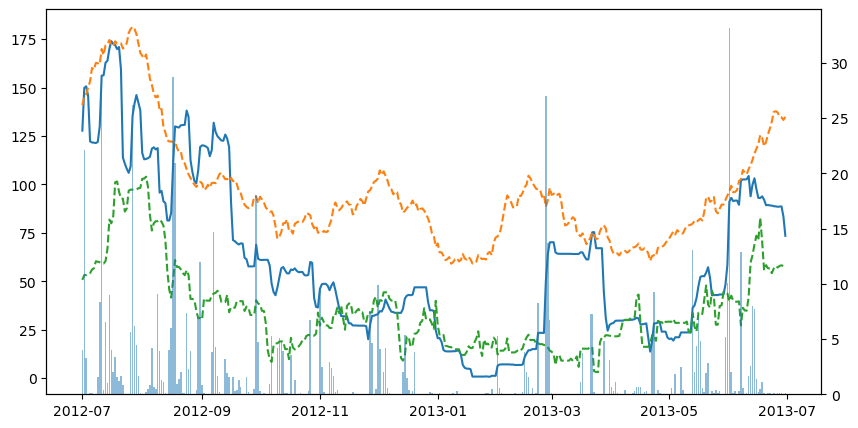

In [488]:
fig,ax=plt.subplots(figsize=(10,5))

ax.plot(df_SILO_year_clim['time'], df_SILO_year_clim['rain_30dayTot'])
ax.plot(df_SILO_year_clim['time'], df_SILO_year_clim['rain_30dayTot_clim'], linestyle='--')
ax.plot(df_SILO_year_clim['time'], df_SILO_year_clim['rain_30dayTot_p10'], linestyle='--')
ax_twin = ax.twinx()
ax_twin.bar(df_SILO_year_clim['time'], df_SILO_year_clim['daily_rain'], alpha=0.5)



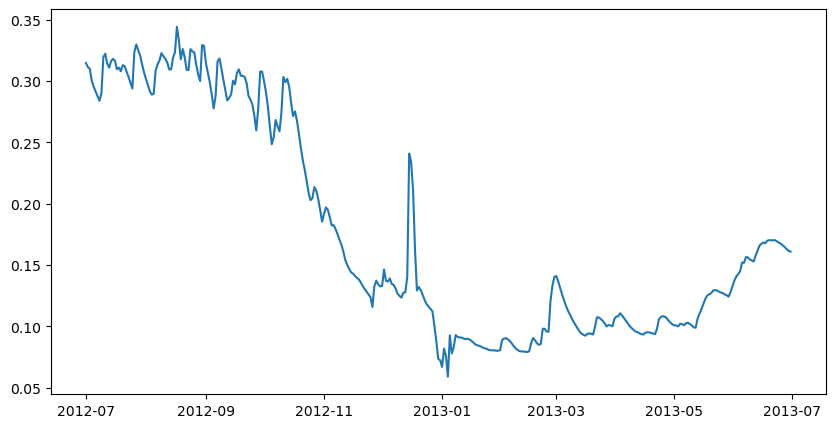

In [489]:
fig,ax=plt.subplots(figsize=(10,5))

ax.plot(df_ozflux_year['time'], df_ozflux_year['Sws_avg'])

## Plots

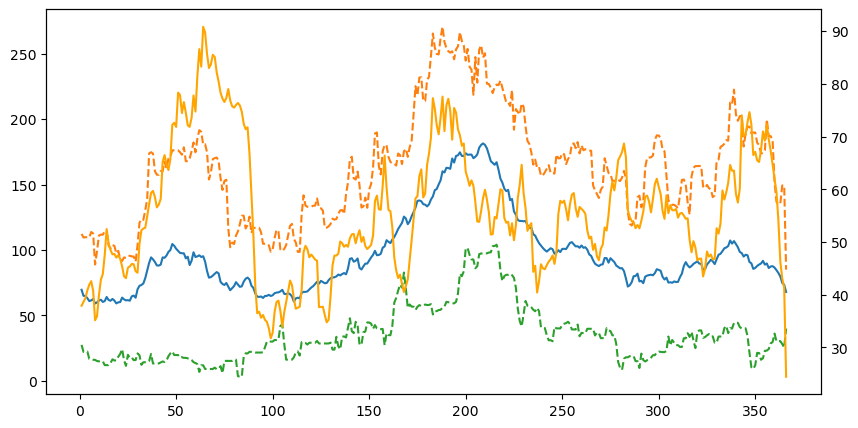

In [353]:
fig,ax=plt.subplots(figsize=(10,5))

ax.plot(df_SILO_clim['dayofyear'], df_SILO_clim['rain_30dayTot_clim'])
ax.plot(df_SILO_clim['dayofyear'], df_SILO_clim['rain_30dayTot_p90'], linestyle='--')
ax.plot(df_SILO_clim['dayofyear'], df_SILO_clim['rain_30dayTot_p10'], linestyle='--')
ax2 = ax.twinx()
ax2.plot(df_SILO_clim['dayofyear'], df_SILO_clim['rain_30dayTot_std'], color='orange')


In [246]:
ds["tmax_anom"] = absolute_anomaly(ds, "max_temp", tmax_clim)
ds["tmax_z"]    = standardised_anomaly(ds, "max_temp", tmax_clim, tmax_std)



In [247]:
ds["rain_30"] = rolling_rain(ds, 30)
ds["rain_90"] = rolling_rain(ds, 90)

rain90_p10 = ds_clim["daily_rain"].rolling(time=90).sum().quantile(0.1)
rain90_mean = ds_clim["daily_rain"].rolling(time=90).sum().mean()
rain30_p10 = ds_clim["daily_rain"].rolling(time=30).sum().quantile(0.1)
rain30_mean = ds_clim["daily_rain"].rolling(time=30).sum().mean()

ds["drought_90"] = ds["rain_90"] < rain90_p10
ds['drought_30'] = ds["rain_30"] < rain30_p10


In [266]:
# Tmax extremes
ds["heat_extreme"] = (
    ds["max_temp"].groupby("time.dayofyear") > tmax_p90
)

ds['tmax_30'] = ds['max_temp'] > 30
ds['tmax_25'] = ds['max_temp'] > 25

# VPD climatology
vpd_clim, vpd_std, _, vpd_p90, vpd_p95 = daily_climatology(ds_clim, "vp_deficit")

ds["vpd_anom"] = absolute_anomaly(ds, "vp_deficit", vpd_clim)
ds["vpd_extreme"] = ds["vp_deficit"].groupby("time.dayofyear") > vpd_p95

# Radiation extremes
rad_clim, _, _, rad_p90, _ = daily_climatology(ds_clim, "radiation")
ds["rad_extreme"] = ds["radiation"].groupby("time.dayofyear") > rad_p90

In [267]:
df = ds[['daily_rain','rain_30','drought_30', 'tmax_anom','max_temp', 'heat_extreme','tmax_25', 'vpd_anom', 'vpd_extreme']].to_dataframe()

## Plots

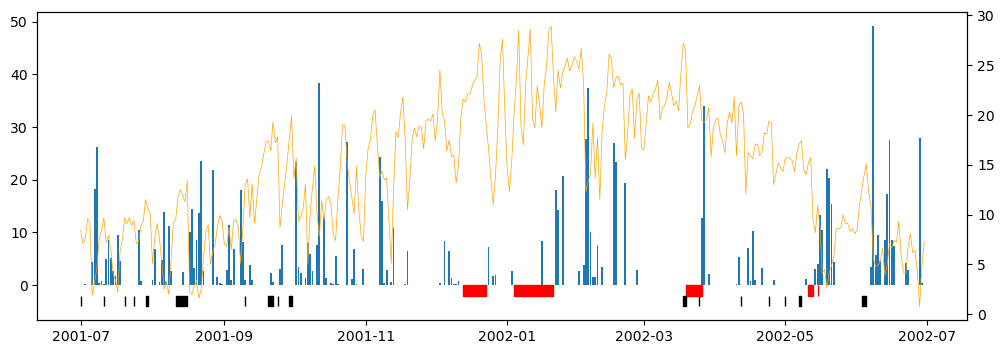

In [287]:
fig, ax1 = plt.subplots(figsize=(12, 4))
ax2 = ax1.twinx()

year =2002
start_date = f'{year-1}-07-01'
end_date = f'{year}-06-30'
df_year = df[(df.index >= start_date) & (df.index <= end_date)]

ax1.bar(df_year.index, df_year["daily_rain"])
ax2.plot(df_year.index, df_year["max_temp"],linewidth=0.5, color='orange')

ymax = -2  # height for shading
ax1.fill_between(
    df_year.index, 0, ymax,
    where=df_year['drought_30'],
    step="post",
    color='red',
    alpha=1
)

ax1.fill_between(
    df_year.index, ymax, ymax-2,
    where=df_year['heat_extreme'],
    step="post",
    color='black',
    alpha=1
)